# Stochastic VI on Probabilistic Count Matrix Factorization

**TODO**: compare the time that Gibbs sampling takes to achieve a certain log-likelihood with CAVI to see who's faster. Then compare with SVI and SGLD.

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import utils, cavi, svi
import plot_utils

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.stats import gamma

plt.style.use('ggplot')

## Data generation

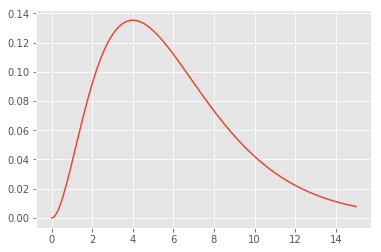

In [2]:
# Look at the Gamma pdf to help deciding the prior parameters for U estimation
a = 3.
b = 0.5

x = np.linspace(0, 15, 1000)

prior_pdf = gamma.pdf(x, a, scale=1./b) 
plt.plot(x, prior_pdf)
plt.show()

In [11]:
# Experiment parameters
N = 1000 # number of observations
P = 10 # observation space dimensionality
K = 2 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.1
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p, 
                                                 eps=eps, return_all=True)

# Run PCA
pca = PCA(n_components=2).fit_transform(Y)

# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('SVI w/ minibatch size = 100:')
inf = svi.StochasticVI(Y, alpha, beta, pi)
svi_100_ll = inf.run_svi(n_iterations=4000, minibatch_size=100, return_ll=True, sampling_rate=1., max_time=60.)
svi_100_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

print('\n')

print('SVI w/ minibatch size = 50:')
inf = svi.StochasticVI(Y, alpha, beta, pi)
svi_50_ll = inf.run_svi(n_iterations=4000, minibatch_size=50, return_ll=True, sampling_rate=1., max_time=60.)
svi_50_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

print('\n')

print('SVI w/ minibatch size = 1:')
inf = svi.StochasticVI(Y, alpha, beta, pi)
svi_1_ll = inf.run_svi(n_iterations=4000, minibatch_size=1, return_ll=True, sampling_rate=1., max_time=60.)
svi_1_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

print('\n')

# Run CAVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('CAVI:')
inf = cavi.CoordinateAscentVI(Y, alpha, beta, pi)
cavi_ll = inf.run_cavi(n_iterations=4000, return_ll=True, sampling_rate=1., max_time=60.)
cavi_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

SVI w/ minibatch size = 100:
Iteration 359/4000. Log-likelihood: -19050.303. Elapsed: 60 seconds

SVI w/ minibatch size = 50:
Iteration 428/4000. Log-likelihood: -19203.674. Elapsed: 60 seconds

SVI w/ minibatch size = 1:
Iteration 394/4000. Log-likelihood: -36755.682. Elapsed: 60 seconds

CAVI:


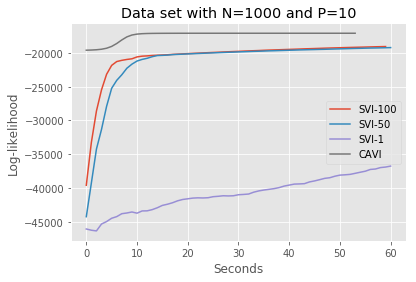

In [12]:
# plt.plot(svi_100_ll[0], label='SVI-100')
# plt.plot(svi_50_ll[0], label='SVI-50')
# plt.plot(svi_1_ll[0], label='SVI-1')
# plt.plot(cavi_ll[0], label='CAVI')
# plt.ylabel('Log-likelihood')
# plt.xlabel('Iteration')
# plt.title('Data set with N={} and P={}'.format(N, P))
# plt.legend()
# plt.show()

plt.plot(svi_100_ll[1], label='SVI-100')
plt.plot(svi_50_ll[1], label='SVI-50')
plt.plot(svi_1_ll[1], label='SVI-1')
plt.plot(cavi_ll[1], label='CAVI')
plt.ylabel('Log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

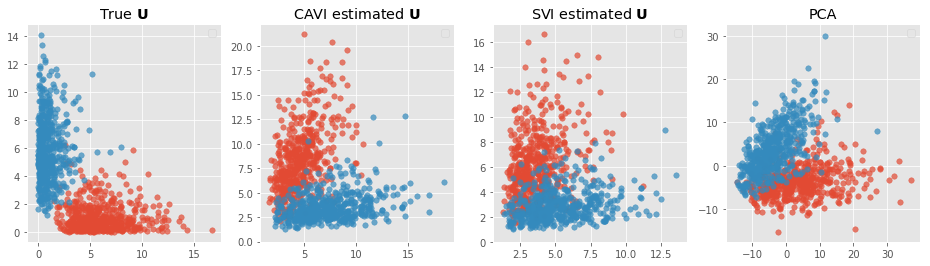

In [16]:
svi_U = svi_50_U

# Plot lower-dimensional embeddings
s = 30
alpha = 0.7
labels=[]
fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot(1, 4, 1)
handlers = []
for c in range(C):
    h = ax1.scatter(U[0, int(c*N/C):int((c+1)*N/C)], U[1, int(c*N/C):int((c+1)*N/C)], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')

ax2 = plt.subplot(1, 4, 2)
handlers = []
for c in range(C):
    h = ax2.scatter(cavi_U[int(c*N/C):int((c+1)*N/C), 0], cavi_U[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('CAVI estimated $\mathbf{U}$')

ax3 = plt.subplot(1, 4, 3)
handlers = []
for c in range(C):
    h = ax3.scatter(svi_U[int(c*N/C):int((c+1)*N/C), 0], svi_U[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax3.legend(handlers, labels, scatterpoints=1)
plt.title('SVI estimated $\mathbf{U}$')

ax4 = plt.subplot(1, 4, 4)
handlers = []
for c in range(C):
    h = ax4.scatter(pca[int(c*N/C):int((c+1)*N/C), 0], pca[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax4.legend(handlers, labels, scatterpoints=1)
plt.title('PCA')

plt.show()

In [17]:
true_silh = silhouette_score(U.T, clusters)
cavi_silh = silhouette_score(cavi_U, clusters)
svi_silh = silhouette_score(svi_U, clusters)
pca_silh = silhouette_score(pca, clusters)

scores = {'CAVI': cavi_silh, 'PCA': pca_silh, 'SVI': svi_silh}
max_key = max(scores, key=scores.get)

print('Silhouette scores (higher is better):')
for key in scores:
    if key == max_key: print('\033[1m', end="")
    print('- ' + key + ': %0.3f' % scores[key] + '\033[0m')
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- CAVI: 0.364
- SVI: 0.262
- PCA: 0.266

Silhouette of true U:
0.573
